
# Variational Autoencoder (VAE) for Swiss Roll Data

In this notebook, you will implement a VAE for 2D Swiss Roll data. The goals are to:
- **Understand VAE components:** the encoder, the decoder, and the reparameterization trick.
- **Implement the reparameterization trick:** Use mean and log-variance to sample latent vectors.
- **Train the VAE** to produce good reconstructions and generate new samples.
  
**Learning Objectives:**
1. Write a correct reparameterization function:
   - Given latent mean $ \mu $ and log-variance $ \log\sigma^2 $, compute the standard deviation and sample using:  
$$
   z = \mu + \epsilon \cdot \sigma \quad \text{with} \quad \epsilon \sim \mathcal{N}(0, I)
$$
2. Implement the VAE loss incorporating both reconstruction loss (MSE) and the closed-form KL divergence loss.
$$
\mathrm{KL}\big(q(z|x)\parallel p(z)\big) = -\frac{1}{2} \sum_{j=1}^{d} \Bigl(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2\Bigr),
$$
4. Visualize reconstructed points and compare generated samples with real Swiss Roll data.

**Your Task:**  
* Implement the **TODO** in the `reparameterize()` method.
* Implement the **TODO** in the `compute_vae_loss()` method.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Swiss Roll Data Generation

This function generates synthetic 2D Swiss Roll data. We'll use it to train the VAE.

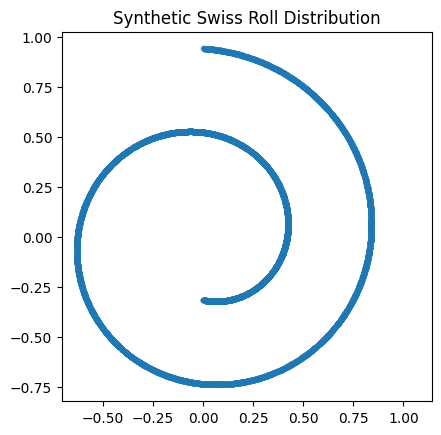

In [2]:
def generate_swiss_roll(n_samples=1000):
    """
    Generate 2D Swiss Roll data points.

    Args:
        n_samples: Number of points to generate.

    Returns:
        torch.Tensor of shape (n_samples, 2)
    """
    # Random parameter t for the roll
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples))
    x = t * torch.cos(t)  # Generate x coordinates
    y = t * torch.sin(t)  # Generate y coordinates
    data = torch.stack([x, y], dim=1) / 15.0  # Scale the data down
    return data

# Visualize generated data:
data = generate_swiss_roll(n_samples=10000)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
plt.title('Synthetic Swiss Roll Distribution')
plt.axis('square')
plt.show()

## VAE Model Definition

The VAE comprises an encoder, a reparameterization module, and a decoder.  
**TODO:** Implement the reparameterization trick in the `reparameterize()` function.

*Hints:*
- Compute the standard deviation using:
  ```python
  std = torch.exp(0.5 * logvar)
  ```
- Draw $ \epsilon $ from a standard normal distribution with the same shape as std using:
```python
eps = torch.randn_like(std)
```
Then return $ z = \mu + eps \times std $.

Fill in the code where the `TODO` is placed

In [3]:
class VAE(nn.Module):
    """
    Variational Autoencoder for 2D data.
    The encoder maps 2D input points to latent parameters.
    The decoder maps latent samples back to 2D points.
    """
    def __init__(self, latent_dim=2, hidden_dim=256):
        super().__init__()

        # Encoder network: transforms 2D input to a hidden representation.
        self.encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Layers to produce the latent mean and log variance.
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder network: transforms latent vector back to 2D output.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Output: 2D coordinate reconstruction.
        )

    def encode(self, x):
        """Encode the input to latent distribution parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: sample a latent vector z from the Gaussian distribution
        defined by mu and logvar.

        **TODO:** Implement the reparameterization trick. Replace None with your code

        Expected steps:
          1. Compute standard deviation: std = exp(0.5 * logvar)
          2. Sample epsilon from a standard normal distribution with the same dimensions as std.
          3. Return mu + eps * std
        """
        # ----- TODO: Student Implementation Starts Here -----
        std = torch.exp(0.5 * logvar)  # Compute the standard deviation from log variance
        eps = torch.randn_like(std)  # Sample epsilon ~ N(0,I) with same shape as std
        return mu + eps*std # Return the reparameterized latent vector
        # ----- TODO: Student Implementation Ends Here -----

    def decode(self, z):
        """Decode a latent vector z to reconstructed points."""
        return self.decoder(z)

    def forward(self, x):
        """Perform a full forward pass: encode -> reparameterize -> decode."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# You may test the forward pass with some dummy data.
# test_data = generate_swiss_roll(5)
# output, _, _ = VAE()(test_data)
# print(output)

tensor([[-0.0062,  0.0656],
        [-0.0228,  0.0704],
        [ 0.0115,  0.0421],
        [-0.0093,  0.0470],
        [ 0.0049,  0.0599]], grad_fn=<AddmmBackward0>)


## Training the VAE

In this cell, we'll train the VAE on Swiss Roll data. The loss consists of:
- **Reconstruction Loss:** Mean Squared Error between input and reconstruction.
- **KL Divergence Loss:** Measures how much the encoded distribution deviates from a unit Gaussian.

The total loss is:
$$
\text{loss} = \text{recon\_loss} + \beta \times \text{KL\_loss}
$$
where $\beta$ scales the KL term.

### Reconstruction Loss

In this VAE implementation, the reconstruction loss is measured by the mean squared error (MSE) between the original input $x$ and its reconstruction $\hat{x}$. In mathematical terms, this loss is expressed as:

$$
\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} \|x_i - \hat{x}_i\|^2,
$$

where $N$ is the number of data points in the batch. This term encourages the decoder to produce outputs that closely resemble the input data.

### KL Divergence Loss

The VAE also includes a regularization term based on the Kullback-Leibler (KL) divergence. The encoder produces a latent representation described by a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ (often represented via $\log \sigma^2$ in the code). The goal is to keep the approximate posterior $q(z|x) = \mathcal{N}(\mu, \sigma^2)$ close to the standard normal prior $p(z) = \mathcal{N}(0, I)$.

The KL divergence between these two distributions is given by:

$$
\mathrm{KL}\big(q(z|x)\parallel p(z)\big) = -\frac{1}{2} \sum_{j=1}^{d} \Bigl(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2\Bigr),
$$

where $d$ is the dimensionality of the latent space. In the code, this is computed with:

```python
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
```

Here, `logvar` represents $\log \sigma^2$ and `logvar.exp()` computes $\sigma^2$.


### Detailed Derivation of the KL Term

The unusual-looking but simple KL divergence loss is a key that makes VAE training work.  It is
the KL divergence between the marginal (prior) Gaussian distribution and the estimated (posterior)
Gaussian distribution proposed by the encoder.  This KL divergence quantifies the exact amount of
information that passes from the encoder to the decoder.

To derive the formula, we start with the definition of the KL divergence between the approximate posterior and the prior:

$$
\mathrm{KL}(q(z|x) \parallel p(z)) = \int q(z|x) \log \frac{q(z|x)}{p(z)} \, dz.
$$

For a diagonal Gaussian, the densities are given by

$$
q(z|x) = \prod_{j=1}^d \frac{1}{\sqrt{2\pi \sigma_j^2}} \exp\left(-\frac{(z_j-\mu_j)^2}{2\sigma_j^2}\right)
$$

and

$$
p(z) = \prod_{j=1}^d \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{z_j^2}{2}\right).
$$

Because the KL divergence decomposes over the dimensions, we can focus on a single dimension and then sum the results. For one dimension, we have:

$$
\mathrm{KL}\big(\mathcal{N}(\mu, \sigma^2) \parallel \mathcal{N}(0,1)\big) = \int \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right) \log \frac{\frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right)}{\frac{1}{\sqrt{2\pi}} \exp\left(-\frac{z^2}{2}\right)} \, dz.
$$

First, simplify the fraction inside the logarithm:

$$
\frac{q(z|x)}{p(z)} = \frac{1}{\sqrt{\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2} + \frac{z^2}{2}\right).
$$

Taking the logarithm gives:

$$
\log \frac{q(z|x)}{p(z)} = -\frac{1}{2}\log \sigma^2 -\frac{(z-\mu)^2}{2\sigma^2} + \frac{z^2}{2}.
$$

Now, taking the expectation with respect to $q(z|x)$, we have:

$$
\mathrm{KL} = -\frac{1}{2}\log \sigma^2 - \frac{1}{2\sigma^2} \mathbb{E}_{q}[(z-\mu)^2] + \frac{1}{2} \mathbb{E}_{q}[z^2].
$$

For $z \sim \mathcal{N}(\mu, \sigma^2)$, it is known that $\mathbb{E}_{q}[(z-\mu)^2] = \sigma^2$ and $\mathbb{E}_{q}[z^2] = \sigma^2 + \mu^2$. Substituting these expectations into the expression yields:

$$
\mathrm{KL} = -\frac{1}{2}\log \sigma^2 - \frac{1}{2} + \frac{1}{2} (\sigma^2 + \mu^2).
$$

Thus, the KL divergence for one dimension simplifies to:

$$
\mathrm{KL}\big(\mathcal{N}(\mu, \sigma^2) \parallel \mathcal{N}(0,1)\big) = \frac{1}{2}\left(\mu^2 + \sigma^2 - \log \sigma^2 - 1\right).
$$

Summing over all dimensions $j = 1, \dots, d$, we obtain the final result:

$$
\mathrm{KL}(q(z|x)\parallel p(z)) = \frac{1}{2}\sum_{j=1}^{d} \left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right),
$$

which is equivalent to the form used in the code:

$$
\mathrm{KL}(q(z|x)\parallel p(z)) = -\frac{1}{2}\sum_{j=1}^{d} \left( 1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right).
$$

This closed-form formula for the KL divergence between Gaussian densities means that the KL term does not require any further numerical integration.

Now your task is to implement this closed-form KL trick in the VAE loss function below.



Training VAE: 100%|██████████| 1000/1000 [00:17<00:00, 56.80it/s, loss=0.0206]


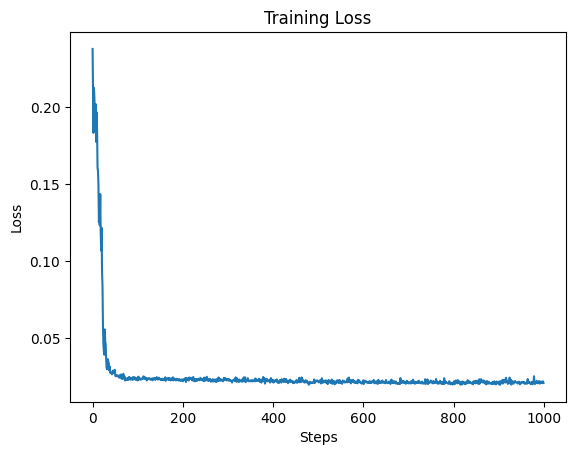

In [4]:
def compute_vae_loss(model, x, beta):
    """
    Perform a forward pass on and compute VAE loss.

    Args:
        model: The VAE model.
        x: A batch of training data.
        beta: Weight for the KL divergence term.

    **TODO:** Implement the closed-form KL divergence, referring to the
    derivation above. Replace None with your code
    """
    # Forward pass.
    recon_x, mu, logvar = model(x)

    # Reconstruction loss (MSE).
    recon_loss = torch.mean((recon_x - x) ** 2)

    # ----- TODO: Student Implementation Starts Here -----
    # KL Divergence loss:
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # TODO: fill in the closed-form KL loss based on the derivation above.
    # ----- TODO: Student Implementation Ends Here -----

    # Total loss.
    loss = recon_loss + beta * kl_loss
    return loss


def train_vae(n_steps=1000, batch_size=128, lr=1e-3, beta=0.01):
    """
    Train the VAE on Swiss Roll data.

    Args:
        n_steps: Number of training steps.
        batch_size: Number of samples per batch.
        lr: Learning rate.
        beta: Weight for the KL divergence term.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model and optimizer.
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []  # To store loss values.
    pbar = tqdm(range(n_steps), desc="Training VAE")

    for step in pbar:
        # Get batch data.
        x = generate_swiss_roll(batch_size).to(device)

        # Compute loss
        loss = compute_vae_loss(model, x, beta)

        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})

    return model, losses, device

# Train the VAE model.
model, losses, device = train_vae()

plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


## Visualizing Reconstructions

We now compare input points with their reconstructions. This helps us measure whether the VAE is learning an
accurate latent representation.
"""

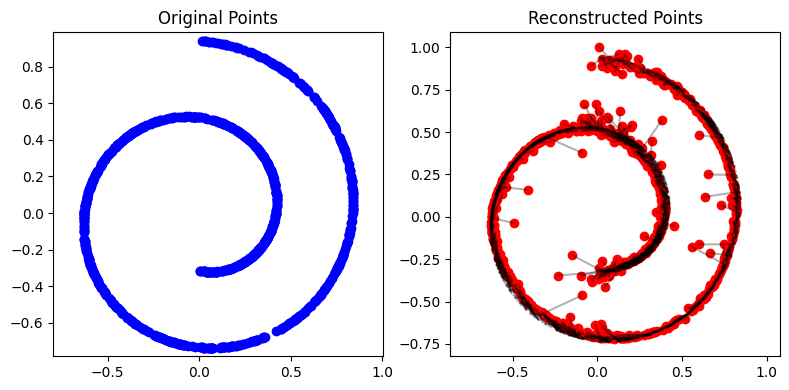

In [5]:
def visualize_reconstructions(model, n_points=1000):
    """
    Visualize original points and their reconstructions.

    Args:
        model: Trained VAE model.
        n_points: Number of test points.
    """
    device = next(model.parameters()).device
    x = generate_swiss_roll(n_points).to(device)

    # Get the reconstructions
    with torch.no_grad():
        recon_x, _, _ = model(x)

    # Convert tensors to numpy arrays.
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(8, 4))

    # Plot original points.
    plt.subplot(1, 2, 1)
    plt.scatter(x[:, 0], x[:, 1], c='blue')
    plt.title('Original Points')
    plt.axis('equal')

    # Plot reconstructions.
    plt.subplot(1, 2, 2)
    plt.scatter(recon_x[:, 0], recon_x[:, 1], c='red')
    plt.title('Reconstructed Points')
    plt.axis('equal')

    # Optionally, draw lines connecting corresponding points.
    for i in range(n_points):
        plt.plot([x[i, 0], recon_x[i, 0]], [x[i, 1], recon_x[i, 1]], 'k-', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize reconstructions.
visualize_reconstructions(model)

## Visualizing the Latent Space

Here we generate a grid of latent vectors and decode them into data space. By comparing with real Swiss Roll data,
you can assess how well the VAE has learned the latent structure.

The grid is defined in the 2D latent space and then decoded to yield generated 2D points.

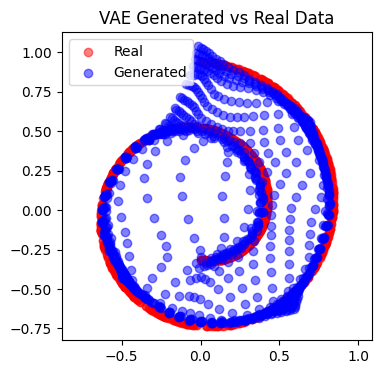

In [6]:
def visualize_latent_space(model, n_points=1000):
    """
    Visualize the learned latent space by decoding a grid of latent vectors.

    Args:
        model: Trained VAE model.
        n_points: Number of grid points (should be a perfect square).
    """
    device = next(model.parameters()).device

    # Create a grid in latent space.
    grid_size = int(np.sqrt(n_points))
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    z_grid = torch.tensor(np.array([[xi, yi] for xi in x for yi in y]), dtype=torch.float32).to(device)

    # Plot real Swiss Roll data for reference.
    real_data = generate_swiss_roll(n_points).numpy()
    plt.figure(figsize=(4, 4))
    plt.scatter(real_data[:, 0], real_data[:, 1], c='red', alpha=0.5, label='Real')

    # Decode the latent grid.
    with torch.no_grad():
        decoded = model.decode(z_grid).cpu().numpy()

    # Plot the decoded points.
    plt.scatter(decoded[:, 0], decoded[:, 1], c='blue', alpha=0.5, label='Generated')

    plt.legend()
    plt.title('VAE Generated vs Real Data')
    plt.axis('equal')
    plt.show()

# Visualize the latent space.
visualize_latent_space(model)


# Task for You

Now that you've seen the complete VAE implementation:
- **Review:** Make sure you understand the reparameterization trick. Why do we need it?
- **Visualize:** Try visualizing the latent space before, during (e.g., each 100 iterations), and after training.  What changes?
- **Experiment:** Modify the VAE architecture or the training parameters. For instance, try changing the latent dimension.
- **Report:** Write your observations regarding reconstruction quality versus latent space continuity.

Happy coding and exploring VAEs!

# Extra Material for Help and Reference
## Understanding VAEs

Imagine you're a curator at an art gallery, and you've been given an interesting challenge. You need to:
1. Study thousands of paintings
2. Learn to describe each painting using just a few numbers
3. Be able to create new, similar paintings just from these number descriptions

This is exactly what a VAE does! The "encoder" is like your brain learning to describe paintings, and the "decoder" is like your ability to imagine a painting from a description.

### Why Is It "Variational"?

Let's extend our analogy. When you describe a painting of a sunset, you might say "lots of orange and red" (let's say that's a number like 8.5 on a scale of 1-10). But should a painting with 8.4 or 8.6 orange-ness look completely different? Of course not!

This is why VAEs don't just encode images to exact points, but to probability distributions. It's like saying "this painting has orange-ness of about 8.5, give or take a bit" rather than exactly 8.5. This "give or take a bit" is what makes it "variational"!

## The Mathematics Breakdown

### The Encoder: Turning Data into Distributions

The encoder in a VAE doesn't just output a point in latent space. Instead, for each input x, it outputs:
- μ (mu): The "best guess" for where this data point should be in latent space
- σ (sigma): How much "wiggle room" we should allow around that guess

Mathematically:
```
q_φ(z|x) = N(μ_φ(x), σ_φ(x))
```

Think of this like plotting a point on a map, but with a circle of uncertainty around it rather than just a dot.

### The Decoder: Bringing Data Back

The decoder takes points from this latent space and tries to reconstruct the original data. It's learning the reverse mapping:
```
p_θ(x|z)
```

### The Loss Function: A Balancing Act

The VAE's loss function has two parts:
1. Reconstruction Loss: "How different is the output from the input?"
2. KL Divergence: "How different is our latent distribution from a standard normal distribution?"

```
L = E[log p_θ(x|z)] - D_KL(q_φ(z|x)||p(z))
```

This is like having two teachers grading your work:
- One checking if your copy matches the original (reconstruction)
- One checking if you're using your latent space efficiently (KL divergence)
  
## Further Reading

For a deeper dive into VAEs, check out these papers:
- Kingma & Welling (2014): "Auto-Encoding Variational Bayes"
- Rezende et al. (2014): "Stochastic Backpropagation and Approximate Inference in Deep Generative Models"
- Carl Doersch (2016): "[Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)"
